In [58]:
import os
import time

import fairness_metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from data_loaders import AdultDataset

from helpers import get_or_train_model

label = "income"
protected_feature = "sex"

start_time = time.time()

# Adult dataset


## Loading Data


In [59]:
adult_dataset = AdultDataset()
adult_df = adult_dataset.load_data()
print(adult_df.shape)
adult_df.head()

(48842, 13)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [60]:
assert adult_df.isnull().sum().sum() == 0
assert len(adult_df["income"].unique()) == 2
assert len(adult_df["sex"].unique()) == 2

In [61]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   marital-status  48842 non-null  object
 4   occupation      48842 non-null  object
 5   relationship    48842 non-null  object
 6   race            48842 non-null  object
 7   sex             48842 non-null  object
 8   capital-gain    48842 non-null  int64 
 9   capital-loss    48842 non-null  int64 
 10  hours-per-week  48842 non-null  int64 
 11  native-country  48842 non-null  object
 12  income          48842 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.8+ MB


In [62]:
adult_dataset_fetures = adult_df.columns.to_list()
adult_dataset_fetures.remove("income")
adult_dataset_fetures

['age',
 'workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

## Comparing the data

Here I'm making sure that the data is the same one that the paper is using.


In [63]:
mask_50k = adult_df["income"] == ">50K"
mask_male = adult_df["sex"] == "Male"
mask_female = adult_df["sex"] == "Female"
previleged_males = sum(mask_50k & mask_male)
previleged_females = sum(mask_50k & mask_female)

print(
    f"{'Males with >50K income: ':<26}",
    previleged_males,
    "-",
    f"{previleged_males / sum(mask_male):.1%} of all males",
)
print(
    "Females with >50K income: ",
    previleged_females,
    "-",
    f"{previleged_females / sum(mask_female):.1%} of all females",
)

Males with >50K income:    9918 - 30.4% of all males
Females with >50K income:  1769 - 10.9% of all females


## Train the model on the original data


In [64]:
train_df, test_df = adult_dataset.get_train_test_data()

assert len(train_df) + len(test_df) == len(adult_df)
assert len(train_df) > 0
assert len(test_df) > 0
assert 0.199 < len(test_df) / (len(train_df) + len(test_df)) < 0.201

In [65]:
models_to_train = {"CAT": {}, "GBM": {}, "RF": {}, "XGB": {}}

predictor = get_or_train_model(
    data=train_df,
    path="ag_models_original_adult_dataset",
    label="income",
    hyperparameters=models_to_train,
)

In [66]:
print(f'\n{"Model":<15} {"ROC AUC":<8} | {"SPD":<5}')

list_protected = np.where(test_df[protected_feature] == "Female", 1, 0)

for model in predictor.get_model_names():
    if "WeightedEnsemble" in model:
        continue

    predictions = predictor.predict_proba(test_df, model=model)[">50K"].to_numpy()

    model_dsp = fairness_metrics.run_all_DSP_thresholds(predictions, list_protected)

    auc_score = predictor.evaluate(test_df, model=model, silent=True)["roc_auc"]
    dsp_std = model_dsp.std()
    spd_mean = model_dsp.mean()

    format_mean_std = f"{spd_mean:.3f} ± {dsp_std:.3f}"

    print(
        f"{model:<15} {auc_score:<8.3f} | {format_mean_std}",
    )

    assert 0.15 > dsp_std > 0.05
    assert 0.20 > spd_mean > 0.15
    assert 0.95 > auc_score > 0.85


Model           ROC AUC  | SPD  


LightGBM        0.927    | 0.190 ± 0.115
RandomForest    0.898    | 0.190 ± 0.096
CatBoost        0.928    | 0.193 ± 0.115
XGBoost         0.927    | 0.191 ± 0.115


### Inference

All the base values are very close to the paper.


## Benchmarking with the synthetic datasets

The paper does not specify how many rows were generated, so I generated 10.000 rows.


In [67]:
# Train dataframe that will be used to train the synthetic datasets
train_df.to_csv("../Datasets/output/adult-train.csv", index=False)

## Loading the synthetic datasets

This dataset was created using Mostly.ai and was augmented by inserting the probabilities for the positive target feature, as well as an interpolation for the unprivileged group to match the probabilities of the previlidges group.


In [68]:
synthetic_df = pd.read_parquet("../Datasets/output/adult-probabilistic.parquet")
synthetic_df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_synthetic,income_model_probability,bin,bin_centers,interpolated_probability
0,51,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1,0.869999,"(0.86999854, 0.87404145]",0.872020,NaN
1,38,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,0,0.083612,"(0.08333528, 0.08666847]",0.085002,0.810357
2,43,Private,Bachelors,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,98,South,0,0.143335,"(0.14000191, 0.14333476]",0.141668,NaN
3,47,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,45,Mexico,0,0.030001,"(0.030001063, 0.030001468]",0.030001,NaN
4,41,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,0.345509,"(0.33947373, 0.34608004]",0.342777,NaN


In [69]:
mask_synthetic_female = synthetic_df["sex"] == "Female"

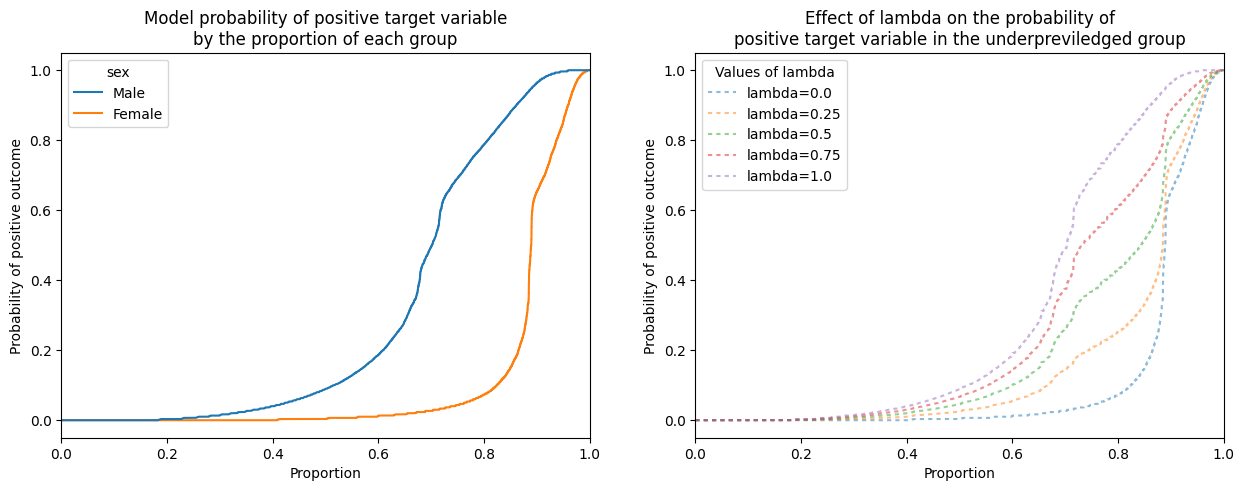

In [70]:
range_lambdas = np.linspace(0, 1, 5)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ax = axs[0]

sns.ecdfplot(
    data=synthetic_df,
    y="income_model_probability",
    hue="sex",
    ax=ax,
)

ax.set(
    title="Model probability of positive target variable\nby the proportion of each group",
    ylabel="Probability of positive outcome",
)

ax = axs[1]

for i_lambda in range_lambdas:
    col_lambda = f"interpolated_probability_lambda={i_lambda}"

    underpreviledged_group_probability = (1 - i_lambda) * synthetic_df[
        "income_model_probability"
    ] + i_lambda * synthetic_df["interpolated_probability"]

    synthetic_df[col_lambda] = np.where(
        mask_synthetic_female,
        underpreviledged_group_probability,
        synthetic_df["income_model_probability"],
    )

    sns.ecdfplot(
        data=synthetic_df.loc[mask_synthetic_female],
        y=col_lambda,
        ax=ax,
        dashes=(2, 2),
        label=f"lambda={i_lambda}",
        alpha=0.5,
        legend=True,
    )

ax.set(
    title="Effect of lambda on the probability of\npositive target variable in the underpreviledged group",
    ylabel="Probability of positive outcome",
)

ax.legend(
    loc="upper left",
    title="Values of lambda",
);  # fmt: skip

In [71]:
synthetic_df.loc[:, adult_dataset_fetures + ["income_model_probability"]]

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_model_probability
0,51,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,8.699990e-01
1,38,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,8.361197e-02
2,43,Private,Bachelors,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,98,South,1.433346e-01
3,47,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,45,Mexico,3.000144e-02
4,41,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,3.455092e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39069,46,Federal-gov,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,8.849979e-01
39070,30,?,Some-college,Never-married,?,Own-child,Black,Male,0,0,50,United-States,1.000131e-02
39071,27,Private,HS-grad,Never-married,Machine-op-inspct,Other-relative,White,Male,0,0,40,United-States,1.668677e-03
39072,56,Federal-gov,Prof-school,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,1.000180e-02


In [72]:
results = {}

target_variable_columns = [
    col for col in synthetic_df.columns if "probability_lambda" in col
]

data = synthetic_df.loc[:, adult_dataset_fetures]
for target in target_variable_columns:
    results[target] = {}

    data["income"] = np.where(synthetic_df[target] > 0.5, ">50K", "<=50K")

    predictor = get_or_train_model(
        data=data,
        path=f"ag_models_synthetic/{target}",
        label="income",
        hyperparameters=models_to_train,
        # run_from_scratch=True,
    )

    print("\n", target)

    print(
        f'{"Model":<13} | {"ROC AUC":<8} | {"Acc.":^5} | {"SPD":^13} | {"TPR1":^13} | {"TPR2":^13}'
    )

    for model in predictor.get_model_names():
        if "WeightedEnsemble" in model:
            continue

        predictions = predictor.predict_proba(test_df, model=model)[">50K"].to_numpy()

        model_dsp = fairness_metrics.run_all_DSP_thresholds(predictions, list_protected)

        model_tpr = fairness_metrics.run_all_TRP_thresholds(
            predictions, list_protected, np.where(test_df["income"] == ">50K", 1, 0)
        )

        model_tpr_1 = model_tpr[:, 0]
        model_tpr_2 = model_tpr[:, 1]

        scores = predictor.evaluate(test_df, model=model, silent=True)
        auc_score = scores["roc_auc"]
        accuracy_score = scores["accuracy"]
        dsp_std = model_dsp.std()
        spd_mean = model_dsp.mean()

        tpr1_mean = model_tpr_1.mean()
        tpr2_mean = model_tpr_2.mean()
        tpr1_std = model_tpr_1.std()
        tpr2_std = model_tpr_2.std()

        assert 0.15 > dsp_std
        assert 0.20 > spd_mean
        assert 0.95 > auc_score > 0.8
        assert 0.90 > accuracy_score > 0.8

        format_mean_std = f"{spd_mean:.3f} ± {dsp_std:.3f}"

        results[target][model] = {
            "AUC": auc_score,
            "SPD_mean": spd_mean,
            "Accuracy": accuracy_score,
            "TPR1": tpr1_mean,
            "TPR2": tpr2_mean,
        }

        print(
            f"{model:<13} | {auc_score:<8.3f} | {accuracy_score:<5.3f} | {format_mean_std} | {tpr1_mean:.3f} ± {tpr1_std:.3f} | {tpr2_mean:.3f} ± {tpr2_std:.3f} | {tpr_diff_mean:^8.3f} | {tpr_diff_std:^8.3f}"
        )


 interpolated_probability_lambda=0.0
Model         | ROC AUC  | Acc.  |      SPD      |     TPR1      |     TPR2     
LightGBM      | 0.921    | 0.866 | 0.183 ± 0.104 | 0.622 ± 0.250 | 0.553 ± 0.232 |  -0.245  |  0.157  
RandomForest  | 0.869    | 0.844 | 0.186 ± 0.069 | 0.607 ± 0.198 | 0.530 ± 0.238 |  -0.245  |  0.157  
CatBoost      | 0.921    | 0.869 | 0.187 ± 0.103 | 0.630 ± 0.243 | 0.557 ± 0.231 |  -0.245  |  0.157  
XGBoost       | 0.922    | 0.868 | 0.186 ± 0.104 | 0.629 ± 0.245 | 0.554 ± 0.227 |  -0.245  |  0.157  

 interpolated_probability_lambda=0.25
Model         | ROC AUC  | Acc.  |      SPD      |     TPR1      |     TPR2     
LightGBM      | 0.921    | 0.870 | 0.180 ± 0.097 | 0.628 ± 0.244 | 0.574 ± 0.229 |  -0.245  |  0.157  
RandomForest  | 0.870    | 0.844 | 0.181 ± 0.066 | 0.605 ± 0.200 | 0.545 ± 0.242 |  -0.245  |  0.157  
CatBoost      | 0.921    | 0.868 | 0.181 ± 0.100 | 0.623 ± 0.245 | 0.565 ± 0.236 |  -0.245  |  0.157  
XGBoost       | 0.921    | 0.868 | 0.182

In [73]:
r = pd.json_normalize(results, sep="#")
r.columns = r.columns.str.split("#").map(tuple)
out = r.stack([0, 1]).reset_index(0, drop=True).swaplevel().sort_index()
out

AUC  Accuracy  \
CatBoost     interpolated_probability_lambda=0.0   0.921479  0.868755   
             interpolated_probability_lambda=0.25  0.921429  0.868243   
             interpolated_probability_lambda=0.5   0.916856  0.863432   
             interpolated_probability_lambda=0.75  0.896520  0.842547   
             interpolated_probability_lambda=1.0   0.890785  0.834869   
LightGBM     interpolated_probability_lambda=0.0   0.921407  0.866196   
             interpolated_probability_lambda=0.25  0.921002  0.870291   
             interpolated_probability_lambda=0.5   0.914227  0.861179   
             interpolated_probability_lambda=0.75  0.896494  0.840500   
             interpolated_probability_lambda=1.0   0.889019  0.831695   
RandomForest interpolated_probability_lambda=0.0   0.868779  0.843878   
             interpolated_probability_lambda=0.25  0.869993  0.843571   
             interpolated_probability_lambda=0.5   0.867062  0.838862   
             interpolated_probability_lambda=0.75  0.850058  0.817260   
             interpolated_probability_lambda=1.0   0.842901  0.809992   
XGBoost      interpolated_probability_lambda=0.0   0.921922  0.867527   
             interpolated_probability_lambda=0.25  0.920601  0.867936   
             interpolated_probability_lambda=0.5   0.917388  0.861998   
             interpolated_probability_lambda=0.75  0.896515  0.839885   
             interpolated_probability_lambda=1.0   0.890523  0.833129   

                                                   SPD_mean      TPR1  \
CatBoost     interpolated_probability_lambda=0.0   0.187233  0.629915   
             interpolated_probability_lambda=0.25  0.180677  0.623454   
             interpolated_probability_lambda=0.5   0.142460  0.620417   
             interpolated_probability_lambda=0.75  0.065578  0.629134   
             interpolated_probability_lambda=1.0   0.051041  0.621502   
LightGBM     interpolated_probability_lambda=0.0   0.182864  0.621916   
             interpolated_probability_lambda=0.25  0.179639  0.627814   
             interpolated_probability_lambda=0.5   0.143735  0.625485   
             interpolated_probability_lambda=0.75  0.070737  0.622747   
             interpolated_probability_lambda=1.0   0.057206  0.629691   
RandomForest interpolated_probability_lambda=0.0   0.185660  0.606833   
             interpolated_probability_lambda=0.25  0.180717  0.605434   
             interpolated_probability_lambda=0.5   0.143525  0.605688   
             interpolated_probability_lambda=0.75  0.053250  0.609506   
             interpolated_probability_lambda=1.0   0.033158  0.607604   
XGBoost      interpolated_probability_lambda=0.0   0.186200  0.629049   
             interpolated_probability_lambda=0.25  0.181707  0.626784   
             interpolated_probability_lambda=0.5   0.142337  0.627013   
             interpolated_probability_lambda=0.75  0.064764  0.624081   
             interpolated_probability_lambda=1.0   0.051118  0.627710   

                                                       TPR2  
CatBoost     interpolated_probability_lambda=0.0   0.556626  
             interpolated_probability_lambda=0.25  0.565062  
             interpolated_probability_lambda=0.5   0.691794  
             interpolated_probability_lambda=0.75  0.854225  
             interpolated_probability_lambda=1.0   0.870392  
LightGBM     interpolated_probability_lambda=0.0   0.552638  
             interpolated_probability_lambda=0.25  0.573932  
             interpolated_probability_lambda=0.5   0.688648  
             interpolated_probability_lambda=0.75  0.853140  
             interpolated_probability_lambda=1.0   0.875003  
RandomForest interpolated_probability_lambda=0.0   0.530232  
             interpolated_probability_lambda=0.25  0.544582  
             interpolated_probability_lambda=0.5   0.673701  
             interpolated_probability_lambda=0.75  0.824142  
             interpolated_probability_lambda=1.0   0.84706

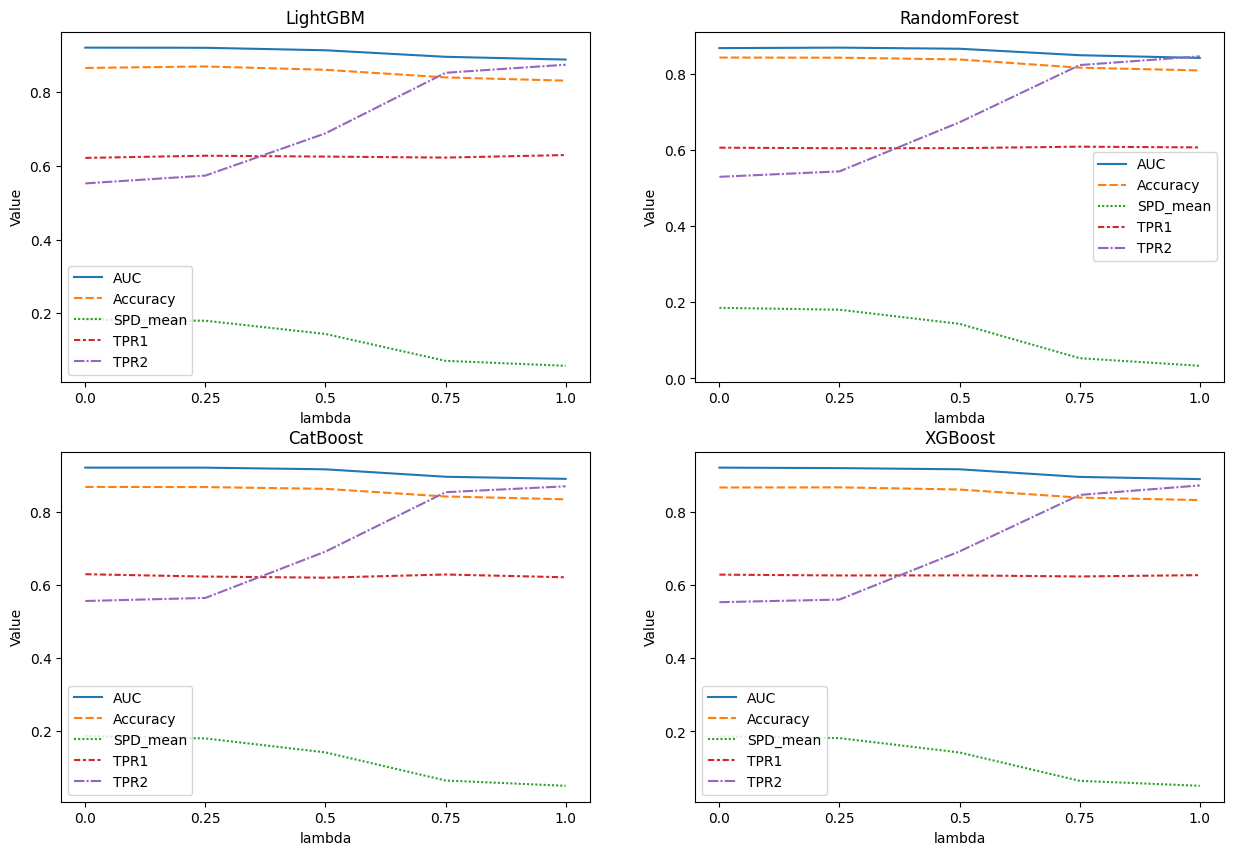

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for ax, model in zip(axs, predictor.get_model_names()):
    if "WeightedEnsemble" in model:
        continue

    sns.lineplot(data=out.loc[model], ax=ax)
    ax.set(
        title=f"{model}",
        ylabel="Value",
        xlabel="lambda",
    )
    ax.set_xticks(np.linspace(0, 4, 5))
    ax.set_xticklabels(np.linspace(0, 1, 5))